In [1]:
#Importing libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [2]:
# Importing train data and diplaying top 5 rows
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DataAnalyst_eureQa/TrainDataSet.csv')
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
## encounter_id,patient_nbr	both are ids and number respectivly so lets drop
data = data.drop(columns=['encounter_id','patient_nbr'])

In [4]:
data = data.replace("?",np.nan)

In [5]:
(data.isna().sum().sort_values(ascending=False)/len(data))*100

weight                      96.677095
payer_code                  52.913613
medical_specialty           41.130588
race                         1.937171
diag_3                       1.767168
diag_2                       0.442863
diag_1                       0.025715
number_outpatient            0.000000
A1Cresult                    0.000000
max_glu_serum                0.000000
number_diagnoses             0.000000
number_inpatient             0.000000
number_emergency             0.000000
num_procedures               0.000000
num_medications              0.000000
diabetesMed                  0.000000
num_lab_procedures           0.000000
time_in_hospital             0.000000
admission_source_id          0.000000
discharge_disposition_id     0.000000
admission_type_id            0.000000
age                          0.000000
gender                       0.000000
metformin                    0.000000
readmitted                   0.000000
nateglinide                  0.000000
tolazamide  

In [6]:
## 96% data missing in weight so lets drop it
data = data.drop(columns=['weight'])

In [7]:
## payer_code, medical_specialty and race replace by new cat
data['race'] = data['race'].fillna('NEWCAT')
data['payer_code'] = data['payer_code'].fillna('NEWCAT')
data['medical_specialty'] = data['medical_specialty'].fillna('NEWCAT')

In [8]:
## 11,19,20,21 removing these ids because patients already deatch so no chance to readmite
data = data[~data['discharge_disposition_id'].isin([11,19,20,21])]

In [9]:
## diag_1, diag_2,diag_3 replacing missing value with newcat
data['diag_1'] = data['diag_1'].fillna('NEWCAT')
data['diag_2'] = data['diag_2'].fillna('NEWCAT')
data['diag_3'] = data['diag_3'].fillna('NEWCAT')

In [10]:
## lets look on medicion columns
tempcol = ['metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

for feat in tempcol:
    print(f"{feat} :")
    print(data[feat].unique())

metformin :
['No' 'Steady' 'Up' 'Down']
repaglinide :
['No' 'Up' 'Steady' 'Down']
nateglinide :
['No' 'Steady' 'Down' 'Up']
chlorpropamide :
['No' 'Steady' 'Down' 'Up']
glimepiride :
['No' 'Steady' 'Down' 'Up']
acetohexamide :
['No' 'Steady']
glipizide :
['No' 'Steady' 'Up' 'Down']
glyburide :
['No' 'Steady' 'Up' 'Down']
tolbutamide :
['No' 'Steady']
pioglitazone :
['No' 'Steady' 'Up' 'Down']
rosiglitazone :
['No' 'Steady' 'Up' 'Down']
acarbose :
['No' 'Steady' 'Up' 'Down']
miglitol :
['No' 'Steady' 'Down' 'Up']
troglitazone :
['No' 'Steady']
tolazamide :
['No' 'Steady' 'Up']
examide :
['No']
citoglipton :
['No']
insulin :
['No' 'Up' 'Steady' 'Down']
glyburide-metformin :
['No' 'Steady' 'Down' 'Up']
glipizide-metformin :
['No' 'Steady']
glimepiride-pioglitazone :
['No']
metformin-rosiglitazone :
['No']
metformin-pioglitazone :
['No']


In [11]:
## examide, citoglipton, glimepiride-pioglitazone,metformin-rosiglitazone and metformin-pioglitazone
## these feature has one unique value so lets drop these features

data= data.drop(columns=['examide', 'citoglipton', 'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone'])

In [12]:
cat_feat = ['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id',
       'payer_code', 'medical_specialty','diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'change', 'diabetesMed']

num_fet = ['time_in_hospital','num_lab_procedures','number_diagnoses',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient']

target = 'readmitted'

http://www.icd9data.com/2012/Volume1/default.htm

Understanding about diagnoses is very hard for non-bio domain. but i find out above URL. as per above Url all the diagnoses are category. so we will treat as category only and missing data treat as new category.  


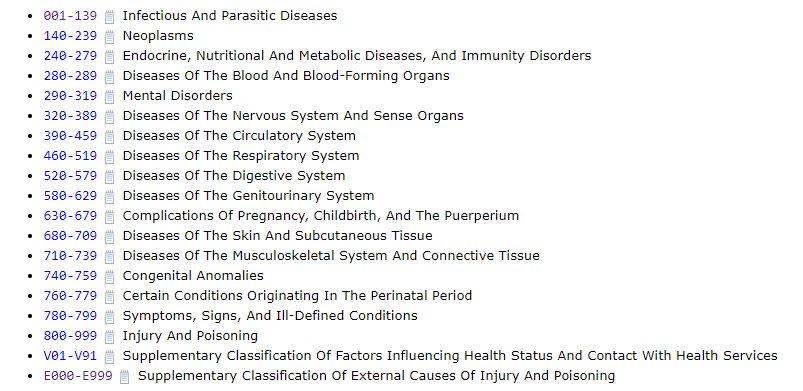

In [13]:
def vrep(x):
    x = str(x)
    if x.startswith('V'):
        return 1000
    elif x.startswith('E'):
        return 2000
    elif x.startswith('N'):
        return 3000
    else:
        return int(float(x))

data['diag_1'] = data['diag_1'].apply(vrep)
data['diag_2'] = data['diag_2'].apply(vrep)
data['diag_3'] = data['diag_3'].apply(vrep)

In [14]:
for i in range(1,4):
    data.loc[(data[f'diag_{i}']>=1) & (data[f'diag_{i}']<=139),f'diag_{i}'] = 0
    data.loc[(data[f'diag_{i}']>=140) & (data[f'diag_{i}']<=239),f'diag_{i}'] = 1
    data.loc[(data[f'diag_{i}']>=240) & (data[f'diag_{i}']<=279),f'diag_{i}'] = 2
    data.loc[(data[f'diag_{i}']>=280) & (data[f'diag_{i}']<=289),f'diag_{i}'] = 3
    data.loc[(data[f'diag_{i}']>=290) & (data[f'diag_{i}']<=319),f'diag_{i}'] = 4
    data.loc[(data[f'diag_{i}']>=320) & (data[f'diag_{i}']<=389),f'diag_{i}'] = 5
    data.loc[(data[f'diag_{i}']>=390) & (data[f'diag_{i}']<=459),f'diag_{i}'] = 6
    data.loc[(data[f'diag_{i}']>=460) & (data[f'diag_{i}']<=519),f'diag_{i}'] = 7
    data.loc[(data[f'diag_{i}']>=520) & (data[f'diag_{i}']<=579),f'diag_{i}'] = 8
    data.loc[(data[f'diag_{i}']>=580) & (data[f'diag_{i}']<=629),f'diag_{i}'] = 9
    data.loc[(data[f'diag_{i}']>=630) & (data[f'diag_{i}']<=679),f'diag_{i}'] = 10
    data.loc[(data[f'diag_{i}']>=680) & (data[f'diag_{i}']<=709),f'diag_{i}'] = 11
    data.loc[(data[f'diag_{i}']>=710) & (data[f'diag_{i}']<=739),f'diag_{i}'] = 12
    data.loc[(data[f'diag_{i}']>=740) & (data[f'diag_{i}']<=759),f'diag_{i}'] = 13
    data.loc[(data[f'diag_{i}']>=760) & (data[f'diag_{i}']<=779),f'diag_{i}'] = 14
    data.loc[(data[f'diag_{i}']>=780) & (data[f'diag_{i}']<=799),f'diag_{i}'] = 15
    data.loc[(data[f'diag_{i}']>=800) & (data[f'diag_{i}']<=999),f'diag_{i}'] = 16
    data.loc[data[f'diag_{i}']==1000,f'diag_{i}'] = 17
    data.loc[data[f'diag_{i}']==2000,f'diag_{i}'] = 18
    data.loc[data[f'diag_{i}']==3000,f'diag_{i}'] = 19

In [15]:
data = data[cat_feat + num_fet + [target]]

In [16]:
cat_map = {}
for feat in cat_feat + [target]:
    if not feat in ['diag_1', 'diag_2', 'diag_3','admission_type_id','discharge_disposition_id','admission_source_id']:
        temp = {}
        for v,k in enumerate(data[feat].unique()):
            temp[k] = v
        cat_map[feat] = temp

def preprocess(data):
    for feat in num_fet:
        data[feat] = data[feat].astype('int')
    for feat,v in cat_map.items():
        data[feat] = data[feat].map(v)
    return data

data = preprocess(data)

Lets Calculate relation between feature and target values.

In [17]:
for feat in num_fet:
    _, p = ttest_ind(data[data[target]==0][feat], data[data[target]==1][feat], equal_var=False)
    print(f"P-Value of {feat} is : {np.round(p,2)}")

P-Value of time_in_hospital is : 0.0
P-Value of num_lab_procedures is : 0.0
P-Value of number_diagnoses is : 0.0
P-Value of num_procedures is : 0.01
P-Value of num_medications is : 0.0
P-Value of number_outpatient is : 0.0
P-Value of number_emergency is : 0.0
P-Value of number_inpatient is : 0.0


here P-values is 0 that means distribution of class are same.

In [18]:
lst = []
for feat in cat_feat:
    cross = pd.crosstab(data[feat],data[target])
    chival = chi2_contingency(cross)

    observed = cross.values
    expected = chival[3]


    nrow = len(cross.iloc[0:2,0])
    ncol = len(cross.iloc[0,0:2])
    dof = (nrow - 1) * (ncol - 1)


    chival = 0
    for o,e in zip(observed,expected):
        chival = chival + ((o - e)**2)/e
    chival = sum(chival)

    p = np.round(1 - chi2.cdf(x = chival,df=dof),2)

    if p>0.05:
        print(f"P-value: {p}, Feature: {feat}")

P-value: 0.58, Feature: gender
P-value: 0.13, Feature: nateglinide
P-value: 0.08, Feature: chlorpropamide
P-value: 0.72, Feature: acetohexamide
P-value: 0.43, Feature: tolbutamide
P-value: 0.23, Feature: miglitol
P-value: 0.53, Feature: troglitazone
P-value: 0.43, Feature: tolazamide
P-value: 0.26, Feature: glyburide-metformin
P-value: 0.8, Feature: glipizide-metformin


above features are corelated with the target value.

High p value high impact with target.

acetohexamide >> gender >> troglitazone

these features are highly impacted feature.

In [19]:
np.var(data[num_fet]).sort_values(ascending=False)

num_lab_procedures    359.653176
num_medications        66.385590
time_in_hospital        9.198632
number_diagnoses        3.992887
num_procedures          2.807979
number_inpatient        1.495152
number_outpatient       1.198318
number_emergency        0.481349
dtype: float64

num_lab_procedures, num_medications
these feature has high variance so these are important features.

## 1.	Provide which attributes are weighted attributes for predict outcome. Why? Please provide some of the relational/mathematical explanation.
* acetohexamide 
* gender 
* troglitazone
* num_lab_procedures
* medical_specialty

these feature will highly impacted features as per my analysis.

In [20]:
np.save('/content/drive/MyDrive/Colab Notebooks/DataAnalyst_eureQa/features.npy',[cat_feat,num_fet,target,cat_map])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


###Model Building:

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.model_selection import RandomizedSearchCV

from collections import defaultdict
class Reponsecode():
  def __init__(self):
    pass
  
  def fit(self,data,feat,tar_feat):

    self.feat = feat
    self.tar_feat = tar_feat

    a = data.groupby([feat,tar_feat],as_index=False)[feat].agg(['count']).reset_index()
    a = a.merge(data.groupby([feat])[feat].agg(['count']).reset_index(),on=feat)

    a['prob'] = a['count_x'] / a['count_y']
    a = a.drop(columns=['count_x','count_y'])

    dic = defaultdict(list)
    self.class_list = []

    for cat in a[feat].unique():
      dic[feat].append(cat)
      for classs in a[tar_feat].unique():
        if len(np.array(a[(a[feat]==cat) & (a[tar_feat]==classs)]['prob']))>0:
          dic[f"{feat}_{classs}"].append(np.array(a[(a[feat]==cat) & (a[tar_feat]==classs)]['prob'])[0])
        else:
          dic[f"{feat}_{classs}"].append(0)
        
        self.class_list.append(f"{feat}_{classs}") 

    self.all_data = pd.DataFrame(dic)
    self.class_list = list(set(self.class_list))
  
  def transform(self,data):
    
    a = data.merge(self.all_data,on=self.feat,how="left")
    a[self.class_list] = a[self.class_list].fillna(0.5)
    a = a.drop(columns=[self.feat])

    return a    

In [38]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DataAnalyst_eureQa/TrainDataSet.csv')

train,test,_,_ = train_test_split(data,data['readmitted'],stratify=data['readmitted'],random_state=0)

In [39]:
## Importing feature anmes and mapping
cat_feat,num_fet,target,cat_map = np.load('/content/drive/MyDrive/Colab Notebooks/DataAnalyst_eureQa/features.npy',allow_pickle=True)

## preprocessing function
def datapreprocess(data,istrain=True):
    def handle_missing(data):
        data['race'] = data['race'].fillna('NEWCAT')
        data['payer_code'] = data['payer_code'].fillna('NEWCAT')
        data['medical_specialty'] = data['medical_specialty'].fillna('NEWCAT')
        data['diag_1'] = data['diag_1'].fillna('NEWCAT')
        data['diag_2'] = data['diag_2'].fillna('NEWCAT')
        data['diag_3'] = data['diag_3'].fillna('NEWCAT')
        return data

    def vrep(x):
        x = str(x)
        if x.startswith('V'):
            return 1000
        elif x.startswith('E'):
            return 2000
        elif x.startswith('N'):
            return 3000
        else:
            return int(float(x))

    def preprocess(data):
        for feat in num_fet:
            data[feat] = data[feat].astype('int')
        for feat,v in cat_map.items():
            if feat=='readmitted':
                if istrain:
                    data[feat] = data[feat].map(v)    
            else:
                data[feat] = data[feat].map(v)
        return data

    
    data = data.drop(columns=['weight','encounter_id','patient_nbr','examide', 'citoglipton', 'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone'])
    data = data.replace(['?'],np.nan)
    data = handle_missing(data)

    

    data['diag_1'] = data['diag_1'].apply(vrep)
    data['diag_2'] = data['diag_2'].apply(vrep)
    data['diag_3'] = data['diag_3'].apply(vrep)

    
    

    for i in range(1,4):
        data.loc[(data[f'diag_{i}']>=1) & (data[f'diag_{i}']<=139),f'diag_{i}'] = 0
        data.loc[(data[f'diag_{i}']>=140) & (data[f'diag_{i}']<=239),f'diag_{i}'] = 1
        data.loc[(data[f'diag_{i}']>=240) & (data[f'diag_{i}']<=279),f'diag_{i}'] = 2
        data.loc[(data[f'diag_{i}']>=280) & (data[f'diag_{i}']<=289),f'diag_{i}'] = 3
        data.loc[(data[f'diag_{i}']>=290) & (data[f'diag_{i}']<=319),f'diag_{i}'] = 4
        data.loc[(data[f'diag_{i}']>=320) & (data[f'diag_{i}']<=389),f'diag_{i}'] = 5
        data.loc[(data[f'diag_{i}']>=390) & (data[f'diag_{i}']<=459),f'diag_{i}'] = 6
        data.loc[(data[f'diag_{i}']>=460) & (data[f'diag_{i}']<=519),f'diag_{i}'] = 7
        data.loc[(data[f'diag_{i}']>=520) & (data[f'diag_{i}']<=579),f'diag_{i}'] = 8
        data.loc[(data[f'diag_{i}']>=580) & (data[f'diag_{i}']<=629),f'diag_{i}'] = 9
        data.loc[(data[f'diag_{i}']>=630) & (data[f'diag_{i}']<=679),f'diag_{i}'] = 10
        data.loc[(data[f'diag_{i}']>=680) & (data[f'diag_{i}']<=709),f'diag_{i}'] = 11
        data.loc[(data[f'diag_{i}']>=710) & (data[f'diag_{i}']<=739),f'diag_{i}'] = 12
        data.loc[(data[f'diag_{i}']>=740) & (data[f'diag_{i}']<=759),f'diag_{i}'] = 13
        data.loc[(data[f'diag_{i}']>=760) & (data[f'diag_{i}']<=779),f'diag_{i}'] = 14
        data.loc[(data[f'diag_{i}']>=780) & (data[f'diag_{i}']<=799),f'diag_{i}'] = 15
        data.loc[(data[f'diag_{i}']>=800) & (data[f'diag_{i}']<=999),f'diag_{i}'] = 16
        data.loc[data[f'diag_{i}']==1000,f'diag_{i}'] = 17
        data.loc[data[f'diag_{i}']==2000,f'diag_{i}'] = 18
        data.loc[data[f'diag_{i}']==3000,f'diag_{i}'] = 19

    
    data = preprocess(data)
    
    

    if istrain:
        data = data[cat_feat + num_fet + [target]]
    else:
        data = data[cat_feat + num_fet]

    return data

In [40]:
train = datapreprocess(train)
test = datapreprocess(test)

x_train = train.drop(columns=[target])
x_test = test.drop(columns=[target])

y_train = train[target]
y_test = test[target]

x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [41]:
## Down Sampling
indexes = x_train[y_train==0].index.values
np.random.shuffle(indexes)
indexes = indexes[:sum(y_train)]

neg = x_train.iloc[indexes,:]
pos = x_train[y_train==1]

pos.shape,neg.shape

x_train = pd.concat([pos,neg])
x_train = x_train.reset_index(drop=True)
y_train = np.array([1] * len(pos) + [0] * len(pos))

indexes = x_train.index.values
np.random.shuffle(indexes)

x_train = x_train.iloc[indexes,:]
y_train = y_train[indexes]

In [42]:
x_train[target] = y_train

responsecode_mapping = {}
for feat in cat_feat:
    rsc = Reponsecode()
    rsc.fit(x_train, feat,target)
    x_train = rsc.transform(x_train)
    x_test = rsc.transform(x_test)
    responsecode_mapping[feat] = rsc
x_train = x_train.drop(columns=[target])

##Logistic regression

In [43]:
lr = LogisticRegression()
lr.fit(x_train,y_train)
y_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

print(f"Train Recall: {recall_score(y_train,y_pred)}")
print(f"Test Recall: {recall_score(y_test,y_test_pred)}")

Train Recall: 0.5833193488840409
Test Recall: 0.5820745216515609


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [44]:
print("Top 5 features:")
for fet in x_train.columns.values[np.argsort(np.abs(np.round(lr.coef_,2)))[0]][:10]:
    print(fet)

Top 5 features:
time_in_hospital
num_lab_procedures
chlorpropamide_1
num_medications
number_outpatient
glyburide-metformin_1
num_procedures
gender_0
tolbutamide_1
acarbose_1


## SVM

In [45]:
from sklearn.svm import SVC
svm = SVC(kernel='linear')
svm.fit(x_train,y_train)
y_pred = svm.predict(x_train)
y_test_pred = svm.predict(x_test)

print(f"Train Recall: {recall_score(y_train,y_pred)}")
print(f"Test Recall: {recall_score(y_test,y_test_pred)}")

Train Recall: 0.527437489511663
Test Recall: 0.5287009063444109


In [46]:
print("Top 5 features:")
for fet in x_train.columns.values[np.argsort(np.abs(np.round(svm.coef_,2)))[0]][:10]:
    print(fet)

Top 5 features:
num_lab_procedures
num_procedures
num_medications
acetohexamide_0
glipizide-metformin_1
glipizide-metformin_0
acetohexamide_1
number_diagnoses
number_outpatient
time_in_hospital


## Random Forest

In [47]:
rf = RandomForestClassifier(n_estimators=100,max_depth=25,min_samples_leaf=1000)
rf.fit(x_train,y_train)
y_pred = rf.predict(x_train)
y_test_pred = rf.predict(x_test)

print(f"Train Recall: {recall_score(y_train,y_pred)}")
print(f"Test Recall: {recall_score(y_test,y_test_pred)}")

Train Recall: 0.596408793421715
Test Recall: 0.595166163141994


In [48]:
rf = RandomForestClassifier()
prams= {
        "max_depth":[5,10,15,20,25,30,40],
    "max_leaf_nodes":[100,200,300,500,1000],
    "n_estimators":[100,200,300,500],
    "min_samples_leaf":[200,500,1000,1500]
}
randomcv = RandomizedSearchCV(rf,param_distributions=prams,verbose=10,n_jobs=-1)
randomcv.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30,
                                                      40],
                                        'max_leaf_nodes': [100, 200, 300, 500,
                                                           1000],
                                        'min_samples_leaf': [200, 500, 1000,
                                                             1500],
                                        'n_estimators': [100, 200, 300, 500]},
                   verbose=10)

In [49]:
randomcv.best_params_

{'max_depth': 20,
 'max_leaf_nodes': 200,
 'min_samples_leaf': 200,
 'n_estimators': 200}

In [50]:
rf = RandomForestClassifier(n_estimators=200,max_depth=20,max_leaf_nodes=200,min_samples_leaf=200)
rf.fit(x_train,y_train)
y_pred = rf.predict(x_train)
y_test_pred = rf.predict(x_test)

print(f"Train Recall: {recall_score(y_train,y_pred)}")
print(f"Test Recall: {recall_score(y_test,y_test_pred)}")

Train Recall: 0.6225876824970633
Test Recall: 0.608257804632427


In [51]:
print("Top 5 features:")
for fet in x_train.columns.values[np.argsort(np.abs(np.round(rf.feature_importances_,2)))][:10]:
    print(fet)

Top 5 features:
repaglinide_0
tolbutamide_1
tolbutamide_0
glyburide_1
glyburide_0
glipizide_1
glipizide_0
pioglitazone_0
acetohexamide_1
glimepiride_1


##Gradiant boosting

In [52]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=200)
xgb.fit(x_train,y_train)
y_pred = xgb.predict(x_train)
y_test_pred = xgb.predict(x_test)

print(f"Train Recall: {recall_score(y_train,y_pred)}")
print(f"Test Recall: {recall_score(y_test,y_test_pred)}")

Train Recall: 0.6449068635677127
Test Recall: 0.6057401812688822


In [53]:
xgb = XGBClassifier()
prams= {
        'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
        'n_estimators':[100,200,500],
        'max_depth':[3,5,10,15]
}
randomcv = RandomizedSearchCV(xgb,param_distributions=prams,verbose=10,n_jobs=-1)
randomcv.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=XGBClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.03, 0.05, 0.1,
                                                          0.15, 0.2],
                                        'max_depth': [3, 5, 10, 15],
                                        'n_estimators': [100, 200, 500]},
                   verbose=10)

In [54]:
randomcv.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

In [55]:
xgb = XGBClassifier(n_estimators=100,max_depth=3,learning_rate=0.1)
xgb.fit(x_train,y_train)
y_pred = xgb.predict(x_train)
y_test_pred = xgb.predict(x_test)

print(f"Train Recall: {recall_score(y_train,y_pred)}")
print(f"Test Recall: {recall_score(y_test,y_test_pred)}")

Train Recall: 0.6299714717234435
Test Recall: 0.6027190332326284


In [56]:
i=0
print("Top 5 features:")
for k,v in xgb.get_booster().get_score(importance_type='gain').items():
    print(k)
    i+=1
    if i>10:
        break

Top 5 features:
number_inpatient
discharge_disposition_id_0
admission_type_id_0
num_medications
number_diagnoses
medical_specialty_0
insulin_0
time_in_hospital
diag_3_0
age_0
diag_1_0


##2.	Develop more than one model: provide what type of parameters in selected model played key role in the prediction and which one best and why?

* number_inpatient
* discharge_disposition_id_0
* admission_type_id_0
* num_medications
* number_diagnoses
* medical_specialty_0
* insulin_0
* time_in_hospital
* diag_3_0
* age_0
* diag_1_0

these feature are best because its information gain is high.

In [57]:
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DataAnalyst_eureQa/TestDataSet.csv')
test_data = datapreprocess(test_data,istrain=False)

In [58]:
for feat,rsc in responsecode_mapping.items():
    test_data = rsc.transform(test_data)

In [60]:
dic = {'lr':lr,'svm':svm,'rf':rf,'xgb':xgb}
pred = pd.DataFrame()
for k,model in dic.items():
    pred[k] = model.predict(test_data)

In [61]:
pred

,lr,svm,rf,xgb
0,0,0,1,0
1,0,0,0,0
2,0,0,0,0
3,1,0,1,1
4,1,1,1,1
...,...,...,...,...
31762,1,1,1,1
31763,1,1,1,1
31764,0,0,0,0
31765,1,1,1,1


In [62]:
pred.to_csv('/content/drive/MyDrive/Colab Notebooks/DataAnalyst_eureQa/final_pred.csv',index=False)